In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import flax
import flax.linen as nn
from functools import partial
import numpyro.distributions as dist
import numpyro
import coix
import optax

import flax.linen as nn

/home/frans/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/frans/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
numpyro.set_platform("cpu")
coix.set_backend("coix.numpyro")

In [3]:
class LSTM_MDN(nn.Module):
    n_mixture_components: int
    n_features: int

    @nn.compact
    def __call__(self, z_prev, x_curr, carry=None):
        x_curr = jnp.repeat(x_curr, z_prev.shape[0], axis=0) # repeat for each particle
        x = jnp.concatenate([z_prev, x_curr], axis=-1)
        # lstm_cell = nn.OptimizedLSTMCell(name="lstm_cell", features=self.n_features)
        # use GRU for now, since I'm not sure how to init the carry for LSTM
        lstm_cell = nn.GRUCell(name="gru_cell", features=self.n_features)
        if carry is None:
            carry = self.param('carry_init', lambda key, shape: jnp.zeros(shape), x.shape[:-1] + (self.n_features,))
        carry, x = lstm_cell(carry, x)
        mu_t = nn.Dense(self.n_mixture_components)(x)
        log_sigma_t = nn.Dense(self.n_mixture_components)(x)
        pi_t = nn.Dense(self.n_mixture_components)(x)
        return mu_t, jnp.exp(log_sigma_t), nn.softmax(pi_t)

In [4]:
lstm_mdn = LSTM_MDN(n_mixture_components=3, n_features=50)

In [5]:
def ssm_proposal(proposal, t, inputs):
    mu_t, sigma_t, pi_t = proposal(inputs["zs"][..., t], inputs["xs"][t])
    k = numpyro.sample("k", dist.Categorical(pi_t))
    z_t = numpyro.sample("z", dist.Normal(mu_t[k], sigma_t[k]))
    return (z_t,)

def ssm_init_target(proposal, t, inputs):
    # t = 0
    z_t_loc, z_t_scale = 0, 5.0
    z_t = numpyro.sample("z", dist.Normal(z_t_loc, z_t_scale))
    numpyro.sample("x", dist.Normal(z_t ** 2 / 20, 1), obs=inputs["xs"][0])
    inputs = {"zs": inputs["zs"].at[:, 0].set(z_t), "xs": inputs["xs"]}
    return (inputs,)

def ssm_target(proposal, t, inputs):
    z_t_m1 = inputs["zs"][..., t-1]
    z_t_loc, z_t_scale = z_t_m1 / 2 + 25 * z_t_m1 / (1 + z_t_m1 ** 2) + 8 * jnp.cos(1.2 * t), jnp.sqrt(10.0)
    z_t = numpyro.sample("z", dist.Normal(z_t_loc, z_t_scale))
    numpyro.sample("x", dist.Normal(z_t ** 2 / 20, 1), obs=inputs["xs"][t])
    inputs = {"zs": inputs["zs"].at[:, t].set(z_t), "xs": inputs["xs"]}
    return (inputs,)

In [29]:
def make_ssm(params, num_particles=10, T_max=1000):
    network = coix.util.BindModule(lstm_mdn, params)
    make_particle_plate = lambda: numpyro.plate("particle", num_particles, dim=-1)
    targets = lambda t: make_particle_plate()(
        partial(ssm_target, network, t)
    )
    proposals = lambda t: make_particle_plate()(
        partial(ssm_proposal, network, t)
    )
    targets = [make_particle_plate()(partial(ssm_init_target, network, 0))] + [targets(t) for t in range(1, T_max)]
    proposals = [proposals(t) for t in range(T_max)]

    # program = coix.algo.nasmc(targets, proposals, num_targets=T_max)
    # return program

    return targets, proposals

In [30]:
def ssm(xs = None, T_max = 1000):
    z_0 = numpyro.sample("z_0", dist.Normal(0, 5))
    z_t_m1 = z_0
    for t in range(1, T_max):
        z_t_loc = z_t_m1 / 2 + 25 * z_t_m1 / (1 + z_t_m1 ** 2) + 8 * jnp.cos(1.2 * t)
        z_t = numpyro.sample(f"z_{t}", dist.Normal(z_t_loc, jnp.sqrt(10)))
        x_t = numpyro.sample(f"x_{t}", dist.Normal(z_t ** 2 / 20, 1), obs=xs[t - 1] if xs is not None else None)
        z_t_m1 = z_t
    return x_t

In [31]:
def loss_fn(params, key, num_particles=10, T_max = 1000):
    shuffle_rng, rng_key = random.split(key)
    tr = numpyro.handlers.trace(numpyro.handlers.seed(ssm, rng_key)).get_trace()
    zs = jnp.zeros((num_particles, T_max))
    xs = jnp.stack([0, *[tr[f"x_{t}"]["value"] for t in range(1, T_max)]])
    assert xs.shape[0] == zs.shape[1] == T_max
    inputs={"zs": zs, "xs": xs}

    program = make_ssm(params, num_particles=num_particles, T_max=T_max)
    _, _, metrics = coix.traced_evaluate(program, seed=rng_key)(inputs)
    return metrics["loss"], metrics

In [53]:
def eval_program(seed, params, num_particles, T_max = 100):
  shuffle_rng, rng_key = random.split(seed)
  tr = numpyro.handlers.trace(numpyro.handlers.seed(ssm, rng_key)).get_trace()
  true_zs = jnp.stack([tr[f"z_{t}"]["value"] for t in range(T_max)])
  print(true_zs)
  zs = jnp.zeros((num_particles, T_max))
  xs = jnp.stack([0, *[tr[f"x_{t}"]["value"] for t in range(1, T_max)]])
  assert xs.shape[0] == zs.shape[1] == T_max
  inputs={"zs": zs, "xs": xs}

  with numpyro.handlers.seed(rng_seed=seed):
    # p = make_ssm(params, num_particles=num_particles, T_max=T_max)
    targets, proposals = make_ssm(params, num_particles=num_particles, T_max=T_max)
  return targets, proposals, inputs, true_zs

In [54]:
num_particles = 2
init_params = lstm_mdn.init(random.PRNGKey(0), z_prev=jnp.zeros((num_particles,)), x_curr=jnp.zeros(1), carry=None)
targets, proposals, inputs, true_zs = eval_program(random.PRNGKey(1), init_params, num_particles)

[ -2.4378479   -7.5218472  -16.62443    -23.732544   -14.601209
  -3.930535     1.8113365    8.232766     0.11860156  -1.6388568
  -6.2521257    0.20377672   8.492458    -5.7904463  -13.144793
  -2.376731    -2.7213185   -7.953932   -14.286436   -14.742748
  -2.6681855   -5.327462    -5.313094   -13.673402   -13.148426
  -9.622785     1.4948101   15.135186    -0.6640425  -20.050045
 -13.614226    -5.393772    -2.4018927  -13.041643   -12.985201
 -12.204583     0.8692436   17.13615     10.470408     0.7940948
   6.4274716   12.074848    13.739754     8.387672     2.78996
  -0.18504477  -4.4926653   -3.742704    -7.151092   -14.935598
 -15.507251    -9.715874     0.53171724  17.175434     2.0267735
   6.377374     2.1863139   13.270082    18.48547     15.152414
   4.709141     2.3775117   13.78477     15.217141    12.260897
  -0.66306555  -9.23083     -3.952919     2.232767    11.064633
   7.7576346    2.4161336    9.51712      9.345994    12.476909
   4.4155684    0.90484476  15.562167 

In [55]:
import functools
q = functools.reduce(lambda a, b: coix.api.compose(b, a), targets[1:], targets[0])

In [56]:
out, trace, metrics = coix.traced_evaluate(q, seed=random.PRNGKey(2))(inputs)

In [57]:
out[0]["zs"].shape

(2, 100)

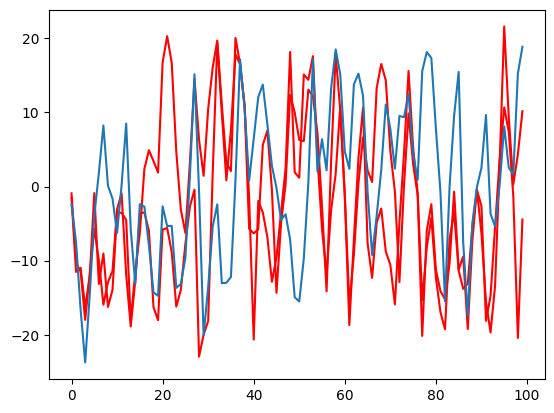

In [62]:
plt.plot(out[0]["zs"].T, color='r')
plt.plot(true_zs)

In [26]:
inputs

{'zs': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32),
 'xs': Array([ 0.00000000e+00,  3.31799841e+00,  

In [28]:
trace

{'z': {'value': Array([1.4958327, 1.2762473], dtype=float32),
  'log_prob': Array([-3.4189043, -3.535359 ], dtype=float32),
  '_event_dim_holder': Array(0., dtype=float32)},
 'x': {'value': Array(17.948332, dtype=float32),
  'log_prob': Array([-159.98853, -160.53186], dtype=float32),
  '_event_dim_holder': Array(0., dtype=float32),
  'is_observed': True}}

In [11]:
# num_particles = 100
# num_steps = 1000
# init_params = lstm_mdn.init(random.PRNGKey(0), z_prev=jnp.zeros((num_particles,)), x_curr=jnp.zeros(1), carry=None)
# lstm_mdn_params, _ = coix.util.train(
#     partial(
#         loss_fn,
#         num_particles=num_particles,
#         T_max = 100,
#     ),
#     init_params,
#     optax.adam(3e-4),
#     num_steps=num_steps,
#     jit_compile=True,
# )